In [10]:
import numpy as np
import h5py

import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input 
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 

In [11]:
PATH = r"/Users/suyashsachdeva/Desktop/gsoc_data.hdf5"
with h5py.File(PATH, 'r') as f:
    data = f['X_jets'][:]


In [12]:
dataset = np.zeros((data.shape[0], 128, 128, 3))
for c in range(data.shape[0]):
    dataset[c, 1:126, 1:126, :] = data[c]

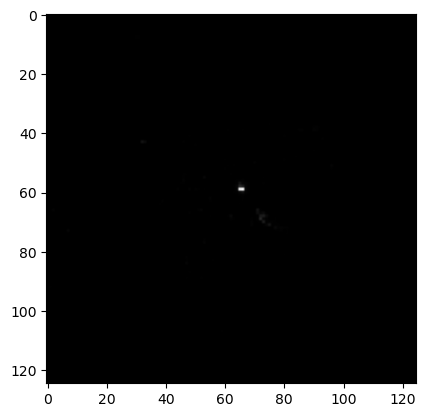

In [13]:
import matplotlib.pyplot as plt 
plt.imshow(data[1, :, :, 1], cmap="grey")

In [28]:

# COnvolutional Block for the autoencoder 
def Conv(x, filters, kernel, strides, pad="same", momentum=0.99, alpha=0.1, transpose=False, gf=2):
    if transpose:     # condition for a convolutional or convolutional transpose operation
        x = Conv2DTranspose(filters, kernel, padding=pad, strides=strides)(x)
        filters = filters//2
    else:
        x = Conv2D(filters, kernel, padding=pad, strides=strides)(x)
        filters = filters * gf 
    x = BatchNormalization(momentum=momentum)(x)
    x = LeakyReLU(alpha)(x)
    return x

# Function for autoencoder 
def AutoEncodeer():
    inp = Input((128, 128, 3))
    x = Conv(inp, 64, 3, 2)
    x = Conv(x, 128, 3, 2)
    x = Conv(x, 256, 3, 2)
    x = Conv(x, 512, 3, 2)
    x = Conv(x, 256, 3, 2, transpose=True)
    x = Conv(x, 128, 3, 2, transpose=True)
    x = Conv(x, 64, 3, 2, transpose=True)
    x = Conv(x, 3, 3, 2, transpose=True)
    model = Model(inputs=inp, outputs=x, name="autoencoder")
    return model 
model = AutoEncodeer()
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_16 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_17 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                      

In [25]:
# PSNR calculation function
def psnr(img1, img2):
  return tf.image.psnr(img1, img2, max_val=1.0)

# SSIM calculation function
def ssim(image1, image2):
    image1 = tf.image.convert_image_dtype(image1, tf.float32)
    image2 = tf.image.convert_image_dtype(image2, tf.float32)
    ssim = tf.image.ssim(image1, image2, max_val=1.0)
    return ssim

In [26]:
traindata = dataset[:100000]
validdata = dataset[100000:]

In [29]:
model.compile(loss="mae", optimizer="adam", metrics=[ "mse", psnr, ssim])
history = model.fit(traindata, traindata, epochs=20, verbose=1, batch_size=64, validation_data=[validdata, validdata], validation_batch_size=64,)

Epoch 1/20


2024-04-02 01:57:36.713684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 0.0010 - mse: 0.0269 - psnr: 67.8820 - ssim: 0.9926

2024-04-02 02:02:04.521477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 312s 199ms/step - loss: 0.0010 - mse: 0.0269 - psnr: 67.8820 - ssim: 0.9926 - val_loss: 7.4645e-04 - val_mse: 1.2150 - val_psnr: 54.3878 - val_ssim: 0.9935
Epoch 2/20
1563/1563 [==============================] - 301s 193ms/step - loss: 2.8068e-04 - mse: 0.0053 - psnr: 72.0186 - ssim: 0.9982 - val_loss: 4.2124e-04 - val_mse: 0.0215 - val_psnr: 63.0592 - val_ssim: 0.9971
Epoch 3/20
1563/1563 [==============================] - 298s 191ms/step - loss: 1.9840e-04 - mse: 0.0023 - psnr: 74.0360 - ssim: 0.9985 - val_loss: 2.5567e-04 - val_mse: 0.0050 - val_psnr: 62.9795 - val_ssim: 0.9970
Epoch 4/20
1563/1563 [==============================] - 296s 189ms/step - loss: 8.1740e-05 - mse: 2.8038e-04 - psnr: 80.6480 - ssim: 0.9993 - val_loss: 5.4107e-05 - val_mse: 3.0474e-04 - val_psnr: 74.1888 - val_ssim: 0.9989
Epoch 5/20
1563/1563 [==============================] - 302s 193ms/step - loss: 4.0912e-05 - mse: 9.5064e-06 - psnr: 84.7899 - ssim: 0.9997 - v

In [38]:
import matplotlib.pyplot as plt
true = dataset[100101]
output = model(dataset[100101].reshape(-1, 128, 128, 3))

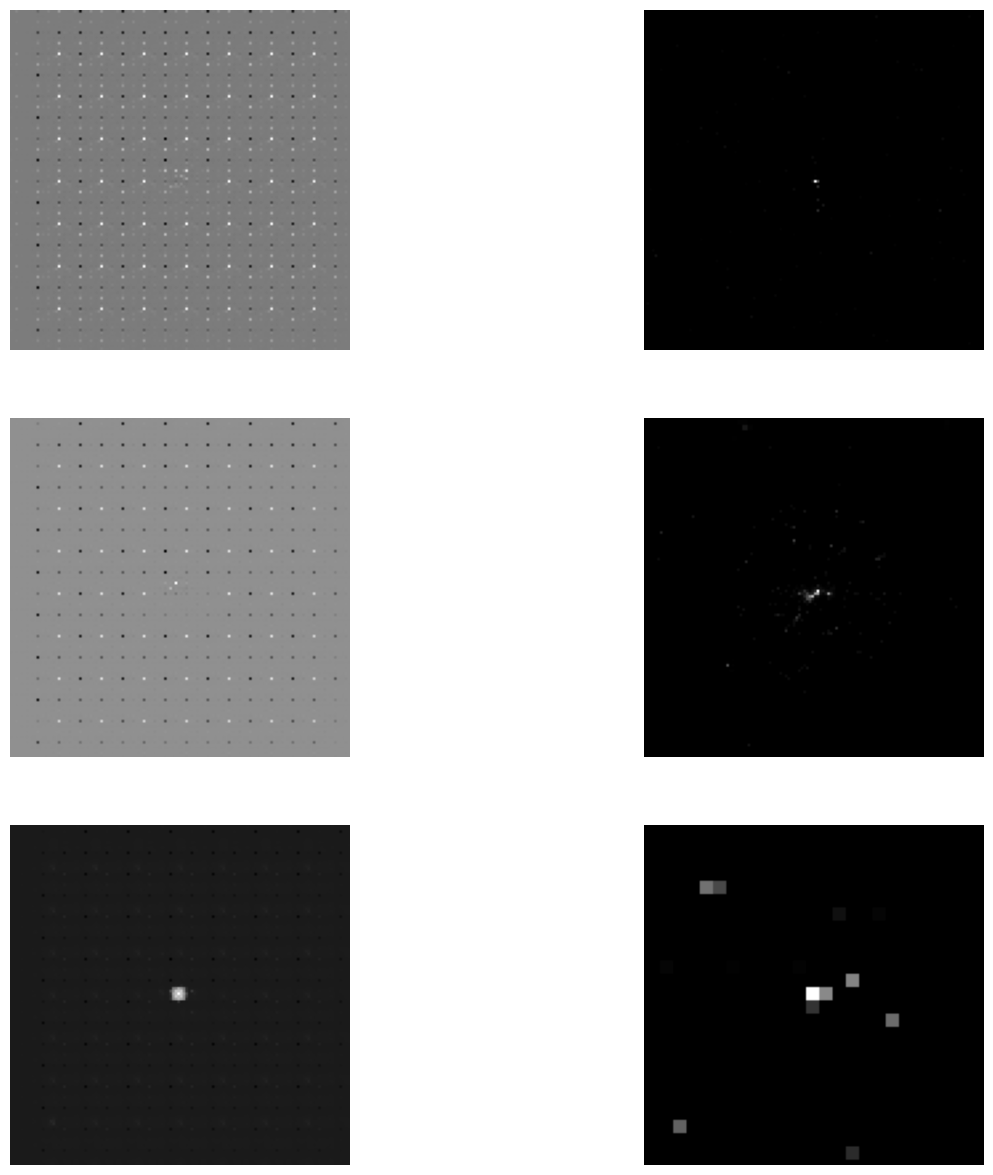

In [39]:
plt.figure(figsize= (15, 3*5))

# Loop through each channel and create a subplot
for i in range(3):
    plt.subplot( 3, 2, i*2+1)  # 1 row, 3 columns, ith subplot
    plt.imshow(output[:, :, :, i][0], cmap='gray')  # Display ith channel
    plt.axis('off')  # Hide axes for clarity

    plt.subplot(3, 2, i*2+2)  # 1 row, 3 columns, ith subplot
    plt.imshow(true[:, :, i], cmap='gray')  # Display ith channel
    plt.axis('off')  # Hide axes for clarity

plt.show()